In [3]:
import picamera
import time
from IPython.display import Image
import math
import serial
import socket
import re
import cv2 as cv

In [4]:
IMAGES_PATH = "images/"
utils = "Utils/"

bottle_cascade = cv.CascadeClassifier(utils + 'biggest_haar.xml')

In [5]:
''''''
''' TCP COMMUNICATION '''
''''''

def enable_tcp_com(BUFFER_SIZE):
    TCP_IP = '192.168.43.58' 
    TCP_PORT = 5005
    while(1):
        try:
            s = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
            s.connect((TCP_IP, TCP_PORT))
            s.setblocking(0)
        except:
            continue
        else:
            print("TCP com enabled!")
            break

    return s

def send_message(s, msg):
    s.send((msg).encode())
    
def check_data_received(s, msg, BUFFER_SIZE):
    ready = select.select([s], [], [], 0.2)
    print(ready)
    if ready[0]:
        data = s.recv(BUFFER_SIZE)
        print(data.decode())
        return data.decode()[-9:] == msg
    else :
        print("Data was not received")
        return None

def close_connection(s):
    s.close()

''''''
''' Robot position '''
''''''


def open_ser():
    ser = serial.Serial(
        port='../../../dev/ttyS0', #Replace ttyS0 with ttyAM0 for Pi1,Pi2,Pi0
        baudrate = 115200,
        parity=serial.PARITY_NONE,
        stopbits=serial.STOPBITS_ONE,
        bytesize=serial.EIGHTBITS,
        timeout=1
    )
    return ser

def get_robot_pos_angle(ser):
    buffer = ''
    ser.flushInput()
    time.sleep(0.1)
    timeout = time.time() + 5 #5s timeout
    while True:
        # last_received = ser.readline()
        buffer += str(ser.read(ser.inWaiting()))
        
        if len(buffer.split('\\n')) >= 3:
            last_received = buffer.split('\\n')[-2]
            pos_angle = re.findall('[+-]?\d+\.\d+', last_received )
            if len(pos_angle) == 3:
                return pos_angle[0], pos_angle[1], pos_angle[2]
        if time.time() > timeout:
            return -1, -1, -1
            break


''''''
''' Bottle position '''
''''''

def calcul_object_pos(xr,yr,ar,dist_rb,a_rb):
    ab = ar + a_rb

    rel_xb = dist_rb * math.cos(math.radians(ab))
    rel_yb = dist_rb * math.sin(math.radians(ab))
    
    real_xb = xr + rel_xb
    real_yb = yr + rel_yb
    return real_xb,real_yb


def calcul_low_center(x,y,w,h):
    return (x+w/2), (y+h)

def multiDimenDist(point1,point2):
   #find the difference between the two points, its really the same as below
    deltaVals = [point2[dimension]-point1[dimension] for dimension in range(len(point1))]
    runningSquared = 0
   #because the pythagarom theorm works for any dimension we can just use that
    for coOrd in deltaVals:
        runningSquared += coOrd**2
    return runningSquared**(1/2)

def findVec(point1,point2,unitSphere = False):
    #setting unitSphere to True will make the vector scaled down to a sphere with a radius one, instead of it's orginal length
    finalVector = [0 for coOrd in point1]
    for dimension, coOrd in enumerate(point1):
        #finding total differnce for that co-ordinate(x,y,z...)
        deltaCoOrd = point2[dimension]-coOrd
        #adding total difference
        finalVector[dimension] = deltaCoOrd
    if unitSphere:
        totalDist = multiDimenDist(point1,point2)
        unitVector =[]
        for dimen in finalVector:
            unitVector.append( dimen/totalDist)
            return unitVector
    else:
        return finalVector

def dotproduct(v1, v2):
    return sum((a*b) for a, b in zip(v1, v2))

def length(v):
    return math.sqrt(dotproduct(v, v))

def calcul_angle(v1, v2):
    return math.acos(dotproduct(v1, v2) / (length(v1) * length(v2)))

def calcul_bottle_dist_angle(center, img_width, img_height):
    vect1 = findVec([img_width/2, img_height],[img_width/2, 0])
    vect2 = findVec([img_width/2, img_height],[center[0],center[1]])
    angle_br = math.degrees(calcul_angle(vect1,vect2))*0.7
    if center[0] > img_width/2:
        angle_br = -angle_br
    dist_y = 20546*(center[1]**(-1.279))
    dist = dist_y / math.cos(math.radians(angle_br))
    return dist, angle_br

# Main

In [10]:
BUFFER_SIZE = 1024
s = enable_tcp_com(BUFFER_SIZE)

TCP com enabled!


In [29]:
camera = picamera.PiCamera()
camera.rotation = 180
camera.resolution = (504, 336)

In [6]:
ser = open_ser()

In [7]:
font = cv.FONT_HERSHEY_SIMPLEX
fontScale = 1
fontColor = (255,255,255)
lineType = 2


In [15]:
get_robot_pos_angle(ser)

('-188.11', '3661.86', '-4.13')

In [9]:
while(True):
    robot_x, robot_y, robot_a = get_robot_pos_angle(ser)
    robot_x = float(robot_x)/10
    robot_y = float(robot_y)/10
    robot_a = float(robot_a)
    '''robot_x= 400
    robot_y = 400
    robot_a = 90'''

    camera.capture(IMAGES_PATH + "cam.bmp")
    img = cv.imread(IMAGES_PATH + 'cam.bmp')

    # resize to increase speed detection
    img_height,img_width = img.shape[:2]   

    bottles = bottle_cascade.detectMultiScale(img, minNeighbors=10)

    bottle_x = []
    bottle_y = []
    i = 0

    for (x,y,w,h) in bottles:
        cv.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
        bottomLeftCornerOfText = (x-10,y-10)
        cv.putText(img,str(i), bottomLeftCornerOfText,font,fontScale,fontColor,lineType)
        center = calcul_low_center(x,y,w,h)
        bottle_dist, bottle_a = calcul_bottle_dist_angle(center, img_width, img_height)
        if bottle_dist < 400:
            cx, cy = calcul_object_pos(robot_x, robot_y, robot_a, 40, bottle_a)
            xb, yb = calcul_object_pos(cx, cy, robot_a, bottle_dist, bottle_a)
            if (xb < 350 and yb > 450) or (xb > 480 and yb > 580) or (xb < 200 and yb < 200) or xb < 10 or yb < 10 or xb > 790 or yb > 790:
                continue
            else:
                bottle_x.append(int(round(xb)))
                bottle_y.append(int(round(yb)))
                tcp_msg = "(" + str(bottle_x[i])+ "," + str(bottle_y[i]) + ");"
                print(("Robot's position: ({},{}), angle: {}").format(robot_x,robot_y,robot_a))
                print(("Bottle's position: {}").format(tcp_msg))
                send_message(s, tcp_msg )
        else:
            continue
        i = i + 1
    

cv.imwrite(IMAGES_PATH + "cam_haar.png", img)
Image(filename = IMAGES_PATH + 'cam_haar.png')

Robot's position: (421.099,470.046), angle: 173.11
Bottle's position: (260,454);
Robot's position: (420.948,464.255), angle: 174.53
Bottle's position: (248,442);
Robot's position: (420.948,464.255), angle: 174.53
Bottle's position: (254,443);
Robot's position: (420.948,464.255), angle: 174.53
Bottle's position: (260,443);
Robot's position: (420.94300000000004,464.255), angle: 174.49
Bottle's position: (241,442);
Robot's position: (421.33599999999996,465.65200000000004), angle: 174.41
Bottle's position: (294,457);
Robot's position: (288.166,450.504), angle: 192.27
Bottle's position: (121,446);
Robot's position: (288.166,450.504), angle: 192.27
Bottle's position: (169,447);
Robot's position: (288.166,450.504), angle: 192.27
Bottle's position: (164,448);
Robot's position: (264.98699999999997,444.584), angle: 195.85
Bottle's position: (95,444);
Robot's position: (264.98699999999997,444.584), angle: 195.85
Bottle's position: (154,465);
Robot's position: (264.98699999999997,444.584), angle: 

Robot's position: (421.139,227.804), angle: -196.32
Bottle's position: (230,193);
Robot's position: (421.139,227.804), angle: -196.32
Bottle's position: (249,233);
Robot's position: (388.959,206.45), angle: -194.46
Bottle's position: (243,198);
Robot's position: (316.49699999999996,222.248), angle: -190.77
Bottle's position: (158,204);
Robot's position: (316.49699999999996,222.248), angle: -190.77
Bottle's position: (182,285);
Robot's position: (270.96,230.475), angle: -188.58
Bottle's position: (118,208);
Robot's position: (257.964,232.151), angle: -186.39
Bottle's position: (102,206);
Robot's position: (253.281,232.64499999999998), angle: -185.09
Bottle's position: (95,207);
Robot's position: (253.196,232.65300000000002), angle: -184.9
Bottle's position: (92,205);
Robot's position: (253.205,232.652), angle: -184.9
Bottle's position: (83,204);
Robot's position: (246.44699999999997,219.225), angle: -184.31
Bottle's position: (105,202);
Robot's position: (186.92000000000002,213.171), an

Robot's position: (445.212,544.113), angle: -444.25
Bottle's position: (447,350);
Robot's position: (445.212,544.113), angle: -444.25
Bottle's position: (502,232);
Robot's position: (445.212,544.113), angle: -444.25
Bottle's position: (399,498);
Robot's position: (445.212,544.113), angle: -444.25
Bottle's position: (390,507);
Robot's position: (445.212,544.113), angle: -444.25
Bottle's position: (425,483);
Robot's position: (446.03900000000004,536.104), angle: -443.77
Bottle's position: (406,488);
Robot's position: (446.038,536.113), angle: -443.77
Bottle's position: (406,488);
Robot's position: (446.038,536.113), angle: -443.77
Bottle's position: (406,488);
Robot's position: (446.038,536.113), angle: -443.77
Bottle's position: (406,488);
Robot's position: (446.038,536.113), angle: -443.77
Bottle's position: (406,488);
Robot's position: (446.038,536.113), angle: -443.77
Bottle's position: (406,488);
Robot's position: (446.83299999999997,509.03000000000003), angle: -452.62
Bottle's posi

KeyboardInterrupt: 

# Haar test

In [42]:
start = time.time()
camera.capture(IMAGES_PATH + "cam.bmp")
img = cv.imread(IMAGES_PATH + 'cam.bmp')
print(time.time() - start)

0.5225706100463867


In [43]:
img_height, img_width = img.shape[:2] 
img.shape[:2] 
print("({},{})".format(img_width,img_height))

(504,336)


In [44]:
#bottle_cascade = cv.CascadeClassifier(utils + 'haar_bottle_20_more_pos.xml')
bottle_cascade = cv.CascadeClassifier(utils + 'biggest_haar.xml')

time: 0.4199516773223877
0 angle: 14.766505617640801
0 dist: 94.4985510177114
(149.0, 69)
1 angle: 11.336831019479112
1 dist: 102.6078514833538
(173.0, 64)
2 angle: 28.278923034984356
2 dist: 72.82980859394011
(43.5, 91)
3 angle: -0.4284777755085685
3 dist: 55.42935287286282
(254.5, 102)
4 angle: 3.5091796285250694
4 dist: 51.61707195209053
(232.0, 108)


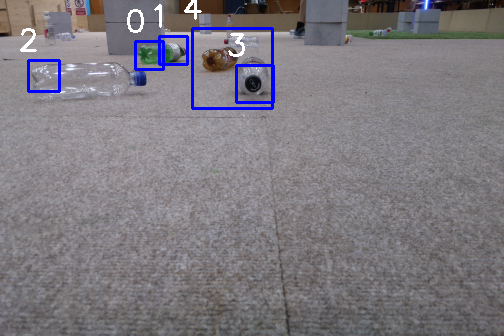

In [45]:
start_time = time.time()
bottles = bottle_cascade.detectMultiScale(img, minNeighbors=6)
print("time: " + str(time.time() - start_time))
i = 0
for (x,y,w,h) in bottles:
    font = cv.FONT_HERSHEY_SIMPLEX
    bottomLeftCornerOfText = (x-10,y-10)
    fontScale = 1
    fontColor = (255,255,255)
    lineType = 2
    cv.putText(img,str(i), bottomLeftCornerOfText,font,fontScale,fontColor,lineType)
    center = calcul_low_center(x,y,w,h)
    dist, angle = calcul_bottle_dist_angle(center, img_width, img_height)
    print(str(i) + " angle: " + str(angle))
    print(str(i) + " dist: " + str(dist))
    print(center)
    cv.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    i = i + 1

cv.imwrite(IMAGES_PATH + "cam_haar.png", img)
Image(filename = IMAGES_PATH + 'cam_haar.png')

# Close connection and camera

In [38]:
camera.close()

In [9]:
close_connection(s)